In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
import preprocess;
import billinfo;

## Functions

In [7]:
"""
method to load the data
congressman: location of the congressman csv
large: whether to use the bert large(True) or distilbert(False) embeddings

"""
def load_data(congressman, large, degree, random_state=42, test_size = 0.2):
    voting_record = pd.read_csv(congressman)
    if not large:
        bill_data = pd.read_csv('distilbert_final_csv.csv')
        finalized_data, cosponsor_categories, committee_categories, subject_categories = preprocess.get_finished_df(voting_record, bill_data)
    else:
        bill_data = pd.read_json('bert_large_final_json.json')
        finalized_data, cosponsor_categories, committee_categories, subject_categories = preprocess.get_finished_df_large(voting_record, bill_data)

    #turn the combined column(which is an array in each row) into a bunch of features
    X = pd.DataFrame(finalized_data['combined'].tolist(), columns=[f'x{i}' for i in range(finalized_data['combined'].iloc[0].size)])
    preprocess.polynomial_features(X, degree=degree)
    y = finalized_data['vote']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return finalized_data, cosponsor_categories, committee_categories, subject_categories, X, y, X_train, X_test, y_train, y_test


#Method to create the neural netwoek, Recall yields the best results
def create_neural_network(X_train, X_test, y_train, y_test, epochs = 20, metric = ['Recall']):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(8192, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(4096, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2048, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1024, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(512, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metric)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)

    train_loss, train_recall = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_recall = model.evaluate(X_test, y_test, verbose=0)

    print(f'Train Loss: {train_loss}, Train Recall: {train_recall}')
    print(f'Test Loss: {test_loss}, Test Recall: {test_recall}')

    # Predictions
    y_train_pred_prob = model.predict(X_train)
    y_test_pred_prob = model.predict(X_test)

    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    report = classification_report(y_test, y_test_pred, target_names=['Yea', 'Nay'])
    print(report)

    save_dir = 'Trained'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.save(os.path.join(save_dir, 'Scott_Peters_CA_Democrat_rep_P000608_2.keras'))

    return model, history, y_train_pred, y_test_pred


#method to train the neural network model
def train_neural_network(congressman, large, epochs=15, metric=['Recall'], degree=1):
    finalized_data, cosponsor_categories, committee_categories, subject_categories, X, y, X_train, X_test, y_train, y_test = load_data(congressman, large, degree=degree)
    model, history, y_train_pred, y_test_pred = create_neural_network(X_train, X_test, y_train, y_test, epochs=epochs, metric=metric)

    print("\nExample Ground Truth and Predictions:")
    print("\nTraining Set:")
    for i in range(5):
        print(f"Ground Truth: {y_train.iloc[i]}, Prediction: {y_train_pred[i][0]}")

    print("\nTest Set:")
    for i in range(5):
        print(f"Ground Truth: {y_test.iloc[i]}, Prediction: {y_test_pred[i][0]}")

    return model, history

#method to load a model from memory
def load_model(location):
    return tf.keras.models.load_model(location)

#function to get a bills info and provide a prediction
def predict(congress, bill_type, bill_number, model, congressman, large):
    bill = billinfo.get_bill_as_df(congress, bill_type, bill_number, congressman, large)

    predicted = model.predict(bill)
    #logistic regression returns a 1d array, neural network returns a 2d array, so this try except needs to be done to get the info
    try:
        if predicted[0,0] < 0.5:
            print(F"Prediction: Yea \n Probability of Yea: {(1-predicted[0,0])*100}% \n Probability of Nay: {predicted[0,0]*100}%")
        else:
            print(F"Prediction: Nay \n Probability of Yea: {(1-predicted[0,0])*100}% \n Probability of Nay: {predicted[0,0]*100}%")
    except:
        if predicted[0] < 0.5:
            print("Prediction: Yea")
        else:
            print("Prediction: Nay")

## Neural Model

### Training the Model

In [8]:
#Select your congressman
congressman = 'congressman_votes_data/Scott_Peters_CA_Democrat_rep_P000608_nan.csv'

#Bert large (True) or distilbert (False)
large = False

print("Neural Network: ")
neural_model, history = train_neural_network(congressman, large=large, epochs=10, metric=['Recall'])

predict(118, 's', 1667, neural_model, congressman, large=large)
predict(118, 'hr', 3442, neural_model, congressman, large=large)

Neural Network: 
Epoch 1/10
45/45 [==============================] - 78s 2s/step - loss: 0.5788 - Recall: 0.0297 - val_loss: 0.2948 - val_Recall: 0.0105
Epoch 2/10
45/45 [==============================] - 76s 2s/step - loss: 0.2959 - Recall: 0.1508 - val_loss: 0.2757 - val_Recall: 0.2875
Epoch 3/10
45/45 [==============================] - 72s 2s/step - loss: 0.2272 - Recall: 0.3599 - val_loss: 0.2444 - val_Recall: 0.4036
Epoch 4/10
45/45 [==============================] - 72s 2s/step - loss: 0.2068 - Recall: 0.4395 - val_loss: 0.2862 - val_Recall: 0.4708
Epoch 5/10
45/45 [==============================] - 73s 2s/step - loss: 0.2183 - Recall: 0.4772 - val_loss: 0.4220 - val_Recall: 0.4936
Epoch 6/10
45/45 [==============================] - 69s 2s/step - loss: 0.1749 - Recall: 0.5148 - val_loss: 0.4159 - val_Recall: 0.5369
Epoch 7/10
45/45 [==============================] - 76s 2s/step - loss: 0.1238 - Recall: 0.5645 - val_loss: 0.3026 - val_Recall: 0.5870
Epoch 8/10
45/45 [=============

### Plotting the fitting curve

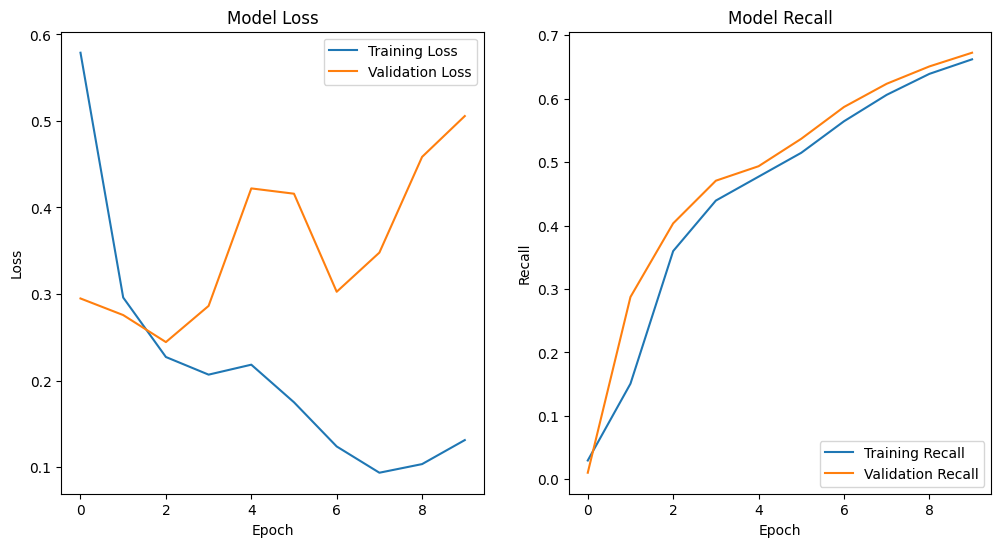

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['Recall'], label = 'Training Recall')
plt.plot(history.history['val_Recall'], label = 'Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()